In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\DELL\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
import os
base_path = r"C:\Users\DELL\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1"
print(os.listdir(base_path))

['Testing', 'Training']


In [1]:
def count_imgs_in_folders(base_dir):
  class_counts = {}
  for cls in os.listdir(base_dir):
    class_path = os.path.join(base_dir , cls)
    if os.path.isdir(class_path):
      class_counts[cls] = len(os.listdir(class_path))
  return class_counts

In [8]:
train_dir= os.path.join(base_path,"Training")
test_dir= os.path.join(base_path,"Testing")

In [9]:
train_counts = count_imgs_in_folders(train_dir)
test_counts = count_imgs_in_folders(test_dir)

In [ ]:
print ("num imgs in Training")
print (train_counts)
print ("num imgs in Testing")
print (test_counts)

num imgs in Training
{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
num imgs in Testing
{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


In [11]:
# Balnce check
total_train = list(train_counts.values())
for cls , count in train_counts.items():
  print (f"{cls}:{count/sum(total_train)*100:.2f}%")

glioma:23.13%
meningioma:23.44%
notumor:27.92%
pituitary:25.51%


In [ ]:
sample_class = list(os.listdir(train_dir))[0]
sample_img_path = os.path.join(train_dir, sample_class, os.listdir(os.path.join(train_dir, sample_class))[0])
img = cv2.imread(sample_img_path)
print("\nSize of original image", img.shape)


Size of original image (512, 512, 3)


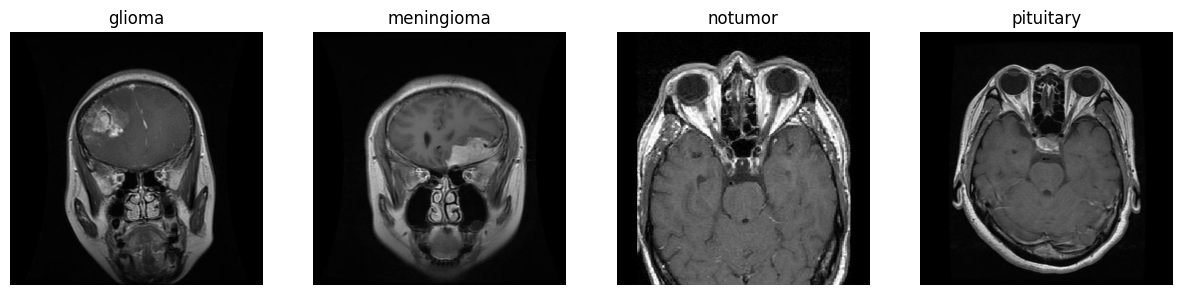

In [13]:
fig, axs = plt.subplots(1, len(train_counts), figsize=(15,5))
for i, cls in enumerate(train_counts.keys()):
    cls_path = os.path.join(train_dir, cls)
    img_path = os.path.join(cls_path, os.listdir(cls_path)[0])
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img_rgb)
    axs[i].set_title(cls)
    axs[i].axis("off")
plt.show()

# ----------------- Data Generators -----------------


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


# ----------------- Model (ResNet50) -----------------


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense , Dropout , Input , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D

base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=Input(shape=(224,224,3)))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation="softmax")(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_resnet_model.h5", save_best_only=True, monitor="val_loss")
]

# Training Phase 1 (Feature Extraction)


In [20]:
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3294 - loss: 1.4909

143/143 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.3710 - loss: 1.3710 - val_accuracy: 0.4479 - val_loss: 1.2278
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4569 - loss: 1.1576

143/143 ━━━━━━━━━━━━━━━━━━━━ 563s 4s/step - accuracy: 0.4776 - loss: 1.1341 - val_accuracy: 0.5302 - val_loss: 1.1696
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5166 - loss: 1.0696

143/143 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.5369 - loss: 1.0547 - val_accuracy: 0.6074 - val_loss: 1.1277
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5929 - loss: 0.9986

143/143 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.5979 - loss: 0.9981 - val_accuracy: 0.6301 - val_loss: 1.0918
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6176 - loss: 0.9730

143/143 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.6200 - loss: 0.9654 - val_accuracy: 0.6135 - val_loss: 1.0764


#  Fine-tuning


In [21]:
print("Fine-tuning phase to unfreeze last 50 layers in ResNet50 ...")
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Fine-tuning phase to unfreeze last 50 layers in ResNet50 ...
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 625s 4s/step - accuracy: 0.5911 - loss: 1.6131 - val_accuracy: 0.2796 - val_loss: 2.5918
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7353 - loss: 0.6509

143/143 ━━━━━━━━━━━━━━━━━━━━ 607s 4s/step - accuracy: 0.7399 - loss: 0.6378 - val_accuracy: 0.7090 - val_loss: 0.9007
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7687 - loss: 0.5507

143/143 ━━━━━━━━━━━━━━━━━━━━ 596s 4s/step - accuracy: 0.7744 - loss: 0.5524 - val_accuracy: 0.7248 - val_loss: 0.7862
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 578s 4s/step - accuracy: 0.7919 - loss: 0.5143 - val_accuracy: 0.7195 - val_loss: 0.7926
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 549s 4s/step - accuracy: 0.8057 - loss: 0.4754 - val_accuracy: 0.6897 - val_loss: 0.8916
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8179 - loss: 0.4552

143/143 ━━━━━━━━━━━━━━━━━━━━ 539s 4s/step - accuracy: 0.8162 - loss: 0.4621 - val_accuracy: 0.7301 - val_loss: 0.6977
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8296 - loss: 0.4248

143/143 ━━━━━━━━━━━━━━━━━━━━ 549s 4s/step - accuracy: 0.8302 - loss: 0.4204 - val_accuracy: 0.7476 - val_loss: 0.6972
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 541s 4s/step - accuracy: 0.8274 - loss: 0.4304 - val_accuracy: 0.7353 - val_loss: 0.7553
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8440 - loss: 0.3870

143/143 ━━━━━━━━━━━━━━━━━━━━ 572s 4s/step - accuracy: 0.8442 - loss: 0.3929 - val_accuracy: 0.7800 - val_loss: 0.6378
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 692s 5s/step - accuracy: 0.8499 - loss: 0.3918 - val_accuracy: 0.7458 - val_loss: 0.7826


In [ ]:
print("Fine-tuning phase to unfreeze last 50 layers in ResNet50 ...")
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Fine-tuning phase to unfreeze last 50 layers in ResNet50 ...
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 625s 4s/step - accuracy: 0.5911 - loss: 1.6131 - val_accuracy: 0.2796 - val_loss: 2.5918
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7353 - loss: 0.6509

143/143 ━━━━━━━━━━━━━━━━━━━━ 607s 4s/step - accuracy: 0.7399 - loss: 0.6378 - val_accuracy: 0.7090 - val_loss: 0.9007
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7687 - loss: 0.5507

143/143 ━━━━━━━━━━━━━━━━━━━━ 596s 4s/step - accuracy: 0.7744 - loss: 0.5524 - val_accuracy: 0.7248 - val_loss: 0.7862
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 578s 4s/step - accuracy: 0.7919 - loss: 0.5143 - val_accuracy: 0.7195 - val_loss: 0.7926
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 549s 4s/step - accuracy: 0.8057 - loss: 0.4754 - val_accuracy: 0.6897 - val_loss: 0.8916
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8179 - loss: 0.4552

143/143 ━━━━━━━━━━━━━━━━━━━━ 539s 4s/step - accuracy: 0.8162 - loss: 0.4621 - val_accuracy: 0.7301 - val_loss: 0.6977
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8296 - loss: 0.4248

143/143 ━━━━━━━━━━━━━━━━━━━━ 549s 4s/step - accuracy: 0.8302 - loss: 0.4204 - val_accuracy: 0.7476 - val_loss: 0.6972
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 541s 4s/step - accuracy: 0.8274 - loss: 0.4304 - val_accuracy: 0.7353 - val_loss: 0.7553
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8440 - loss: 0.3870

143/143 ━━━━━━━━━━━━━━━━━━━━ 572s 4s/step - accuracy: 0.8442 - loss: 0.3929 - val_accuracy: 0.7800 - val_loss: 0.6378
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 692s 5s/step - accuracy: 0.8499 - loss: 0.3918 - val_accuracy: 0.7458 - val_loss: 0.7826


# Test Evaluation

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print("Final Test Accuracy:", test_acc)

Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.8047 - loss: 0.5324
Final Test Accuracy: 0.8047292232513428


In [ ]:
# Save the full model (architecture + weights + optimizer state)
model.save("brain_tumor_resnet50.keras")